In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray
import rasterio
import matplotlib.pyplot as plt
import pyproj
import warnings

from functools import partial
from shapely.ops import transform
from keplergl import KeplerGl
from shapely.geometry import mapping
from shapely.wkt import loads
from rasterio import plot

import sys
sys.path.insert(1, '../config/')
import kepler_configs



%matplotlib inline
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

In [2]:
def flip(x, y):
    """Flips the x and y coordinate values"""
    return y, x

## masking Lahore data

In [3]:
tiff_path = '../data/raster/PAK_2020.tif'
rds = rioxarray.open_rasterio(tiff_path, parse_coordinates=True)
district_shp_path  = '../data/vector/pak_administrative_shapefiles/District_Boundary.shp'
districts_gpd = gpd.read_file(district_shp_path)


In [4]:
rds.rio.crs

CRS.from_epsg(4326)

In [5]:
proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
               pyproj.Proj(init='epsg:3857'))

In [6]:
poly = districts_gpd[districts_gpd.DISTRICT.isin(['LAHORE'])].geometry.values[0]
geom = mapping(loads(str(poly)))

In [7]:
lahore_pop = rds.rio.clip([geom],'EPSG:4326',drop=True)
lahore_pop.rio.to_raster('../data/raster/lahore_masked.tiff')
lahore_pop = rasterio.open('../data/raster/lahore_masked.tiff')

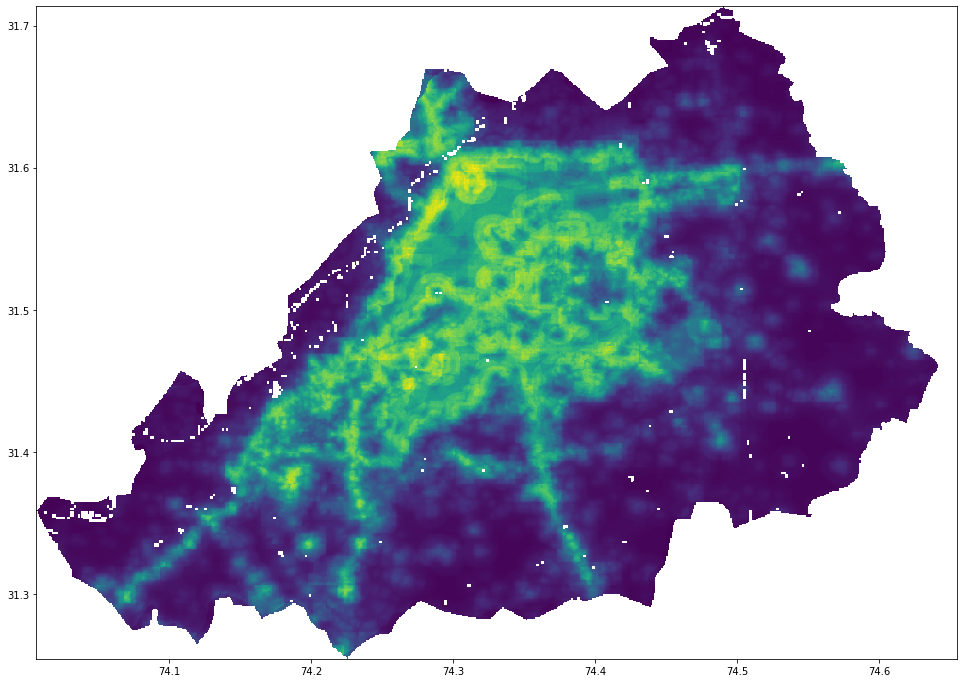

<AxesSubplot:>

In [8]:
fig = plt.figure(figsize=(18,12))
plot.show(lahore_pop)


## comparing raster data with other estimates

In [9]:
tiff_path = '../data/raster/PAK_2020.tif'
rds = rioxarray.open_rasterio(tiff_path, parse_coordinates=True)
district_shp_path  = '../data/vector/pak_administrative_shapefiles/District_Boundary.shp'
districts_gpd = gpd.read_file(district_shp_path)


In [10]:
districts_gpd.DISTRICT.values

array(['BAGH', 'BHIMBER', 'HATTIAN BALA', 'HAVELI', 'KOTLI', 'MIRPUR',
       'MUZAFFARABAD', 'NEELUM', 'POONCH', 'SUDHNOTI', 'AWARAN',
       'BARKHAN', 'CHAGAI', 'DERA BUGTI', 'GWADAR', 'HARNAI',
       'JAFFARABAD', 'JHAL MAGSI', 'KACHHI', 'KALAT', 'KECH', 'KHARAN',
       'KHUZDAR', 'KILLA ABDULLAH', 'KILLA SAIFULLAH', 'KOHLU', 'LASBELA',
       'LORALAI', 'MASTUNG', 'MUSA KHEL', 'NASIRABAD', 'NUSHKI',
       'PANJGUR', 'PISHIN', 'QUETTA', 'SHEERANI', 'SIBI', 'WASHUK',
       'ZHOB', 'ZIARAT', 'INDIAN OCCUPIED KASHMIR', 'BAJAUR AGENCY',
       'FR BANNU', 'FR D.I.KHAN', 'FR KOHAT', 'FR LAKKI MARWAT',
       'FR PESHAWAR', 'FR TANK', 'KURRAM AGENCY', 'MOHMAND AGENCY',
       'N. WAZIRASTAN', 'ORAKZAI AGENCY', 'S. WAZIRASTAN', 'ISLAMABAD',
       'ASTORE', 'DIAMIR', 'GHANCHE', 'GHIZER', 'GILGIT', 'HUNZA NAGAR',
       'SKARDU', 'ABBOTTABAD', 'BANNU', 'BATAGRAM', 'BUNER', 'CHARSADDA',
       'CHITRAL', 'D I KHAN', 'HANGU', 'HARIPUR', 'KARAK', 'KOHAT',
       'UPPER KOHISTAN', 'LAKKI M

In [13]:
cities = ['LAHORE','RAWALPINDI','KARACHI CENTRAL','KARACHI SOUTH','PESHAWAR','MULTAN','SWABI','SWAT']
cities = districts_gpd.DISTRICT.unique()
path = '../data/raster/city_masked.tiff'

In [14]:
district_stats = []
for city in cities:
    print(city)
    poly = districts_gpd[districts_gpd.DISTRICT.isin([city])].geometry.values[0]
    geom = mapping(loads(str(poly)))
    city_pop = rds.rio.clip([geom],'EPSG:4326',drop=True)
    city_pop_no_zeros = city_pop.where(city_pop != 0, np.nan)
    sum_pop = city_pop_no_zeros.sum().values.item()
    mean_pop = city_pop_no_zeros.mean().values.item()
    max_pop = city_pop_no_zeros.max().values.item()
    min_pop = city_pop_no_zeros.min().values.item()
    std_pop = city_pop_no_zeros.std().values.item()
    
    val_dict = {
    'district':city,
    'sum_pop':sum_pop,
    'mean_pop':mean_pop,
    'max_pop':max_pop,
    'min_pop':min_pop,
    'std_pop':std_pop
    }
    print(val_dict)
    district_stats.append(val_dict)
    


BAGH
{'district': 'BAGH', 'sum_pop': 317178.375, 'mean_pop': 3.8600733280181885, 'max_pop': 43.87288284301758, 'min_pop': 0.77279132604599, 'std_pop': 3.2099366188049316}
BHIMBER
{'district': 'BHIMBER', 'sum_pop': 315563.15625, 'mean_pop': 2.2669765949249268, 'max_pop': 31.80043601989746, 'min_pop': 0.610798180103302, 'std_pop': 2.0396347045898438}
HATTIAN BALA
{'district': 'HATTIAN BALA', 'sum_pop': 185078.78125, 'mean_pop': 2.322542667388916, 'max_pop': 17.422922134399414, 'min_pop': 0.45982638001441956, 'std_pop': 1.7859519720077515}
HAVELI
{'district': 'HAVELI', 'sum_pop': 124532.8671875, 'mean_pop': 2.0195391178131104, 'max_pop': 13.256771087646484, 'min_pop': 0.6789115071296692, 'std_pop': 1.1385201215744019}
KOTLI
{'district': 'KOTLI', 'sum_pop': 631795.0, 'mean_pop': 3.3342745304107666, 'max_pop': 91.63841247558594, 'min_pop': 0.474822998046875, 'std_pop': 3.9645397663116455}
MIRPUR
{'district': 'MIRPUR', 'sum_pop': 280786.59375, 'mean_pop': 2.966233015060425, 'max_pop': 40.071

In [16]:
district_pop_df = pd.DataFrame(district_stats)
district_pop_df.to_csv('../data/processed/distiricts_wp_pop.csv',index=False)

In [64]:
pd.DataFrame(district_stats).to_csv('../data/summary-stats/worldpop_pop_sample.csv',index=False)

In [124]:
district_comp = pd.read_csv('../data/summary-stats/worldpop_pop_sample.csv')

In [126]:
#data pulled from pbs 2017 census
district_comp

,district,sum_pop,mean_pop,max_pop,min_pop,pbs_2017,pct_diff
0,LAHORE,9339700.000,47.850746,173.616516,2.791250,11119985,8.701429
1,RAWALPINDI,4979794.000,7.983433,131.925354,0.568600,5402380,4.070304
2,KARACHI CENTRAL,2843387.750,417.838013,690.677063,22.974747,2971382,2.201192
3,KARACHI SOUTH,2073177.500,322.172119,595.840210,18.367601,1769230,-7.910340
4,PESHAWAR,3110161.750,20.484905,147.951370,1.786726,4267198,15.683609
5,MULTAN,4662498.000,11.134537,191.284531,1.394589,4746166,0.889265
6,SWABI,1615530.625,9.206929,74.477226,0.688275,1625477,0.306891
7,SWAT,1981306.875,3.008471,136.870697,0.014356,2308624,7.629893


## aggregate grid with raster values

In [6]:
# ~1000x1000m grid loading
lahore_grid = gpd.read_file('../data/vector/dev/LAHORE/lahore_voronoi_fishnet_1000m.shp')

In [7]:
poly = districts_gpd[districts_gpd.DISTRICT.isin(['LAHORE'])].geometry.values[0]
# creating small buffer just we can clip edge tesselations properly
poly = poly.buffer(0.001)
geom = mapping(loads(str(poly)))
lahore_pop = rds.rio.clip([geom],'EPSG:4326',drop=True)

In [8]:
grid_stats = []
for ind,row in lahore_grid.iterrows():
#     print(row.vor_id)
    poly = row.geometry
    poly = transform(flip, poly)
    geom = mapping(loads(str(poly)))
    grid_pop = lahore_pop.rio.clip([geom],'EPSG:4326',drop=True)
    sum_pop = grid_pop.sum().values.item()
    mean_pop = grid_pop.mean().values.item()
    max_pop = grid_pop.max().values.item()
    min_pop = grid_pop.min().values.item()
    
    
    val_dict = {
    'vor_id':row.vor_id,
    'sum_pop':sum_pop,
    'mean_pop':mean_pop,
    'max_pop':max_pop,
    'min_pop':min_pop
    }
    grid_stats.append(val_dict)

In [9]:
grid_stats_df = pd.DataFrame(grid_stats)

In [13]:
grid_stats_df

,vor_id,sum_pop,mean_pop,max_pop,min_pop
0,vor0,2285.573242,10.024444,17.961241,6.825547
1,vor1,2685.794922,7.143072,11.238690,3.979286
2,vor2,2206.518311,5.614551,8.093608,3.967151
3,vor3,7413.843750,18.534609,72.394005,4.929726
4,vor4,2556.938965,7.520409,12.826985,6.090775
...,...,...,...,...,...
575,vor575,8.571218,8.571218,8.571218,8.571218
576,vor576,586.866577,7.523931,9.867419,6.351686
577,vor577,2131.020752,9.865837,13.815136,6.525647
578,vor578,2250.155762,15.518315,34.314877,8.026274


In [12]:
grid_stats_df[:-1].to_csv('../data/summary-stats/lhr_pop_vor.csv',index=False)

In [104]:
lahore_grid_with_pop = lahore_grid.merge(grid_stats_df)
lahore_grid_with_pop = lahore_grid_with_pop.dropna()
lahore_grid_with_pop['geometry'] = lahore_grid_with_pop.geometry.apply(lambda x: transform(flip,x))
lahore_grid_with_pop_gpd = gpd.GeoDataFrame(lahore_grid_with_pop,geometry='geometry')

In [120]:
map_ = KeplerGl(height=500)
map_.add_data(data=lahore_grid_with_pop_gpd,name='lahore_pop')
map_.save_to_html(file_name='../viz/temp.html')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [130]:
map_.save_to_html(file_name='../viz/lahore_pop_grid.html',config=kepler_configs.lahore_pop_grid,read_only=True)

Map saved to ../viz/lahore_pop_grid.html!


## FACEBOOK DATA

In [9]:
tiff_path = '../data/raster/fb_raw/population_ind_pak_general/population_ind_pak_general/population_30_lon_70_general-v1.5.tif'
rds = rioxarray.open_rasterio(tiff_path, parse_coordinates=True)
district_shp_path  = '../data/vector/pak_administrative_shapefiles/District_Boundary.shp'
districts_gpd = gpd.read_file(district_shp_path)

In [10]:
proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
               pyproj.Proj(init='epsg:3857'))

In [11]:
poly = districts_gpd[districts_gpd.DISTRICT.isin(['LAHORE'])].geometry.values[0]
geom = mapping(loads(str(poly)))

In [ ]:
lahore_pop_fb = rds.rio.clip([geom],'EPSG:4326',drop=True)


In [23]:
lahore_pop_fb.rio.to_raster('../data/raster/lahore_masked_pop_fb.tiff')

In [24]:
lahore_pop_fb = rasterio.open('../data/raster/lahore_masked_pop_fb.tiff')

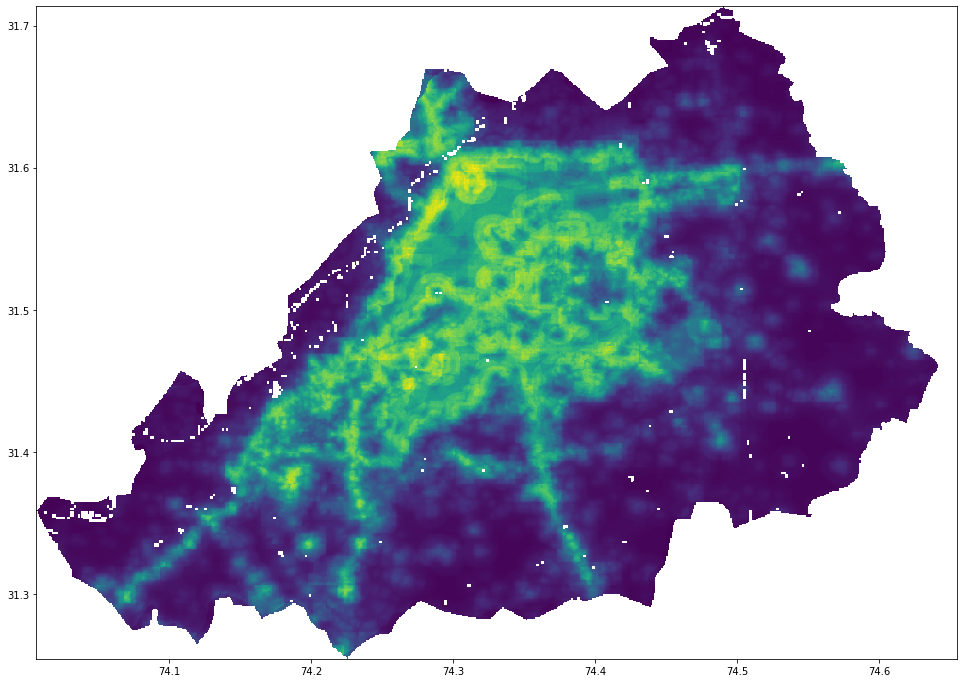

<AxesSubplot:>

In [25]:
fig = plt.figure(figsize=(18,12))
plot.show(lahore_pop_fb)
